In [28]:
import os
import torch
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
import json
import cv2
import copy as cp
import math
from PIL import Image
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import pickle

%reload_ext autoreload
%autoreload 2

In [29]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

### Import pifpaf

In [30]:
images_names=os.listdir('../../../pedestrianDepth-baseline/MonoDepth-PyTorch/data/test/image_2/image_02/data/')
images_names.sort()

In [31]:
labels_names=os.listdir('data/mask_c/')
labels_names.sort()

In [32]:
labels_names[0:10]

['000000_mask.json',
 '000005_mask.json',
 '000006_mask.json',
 '000007_mask.json',
 '000008_mask.json',
 '000010_mask.json',
 '000011_mask.json',
 '000015_mask.json',
 '000018_mask.json',
 '000021_mask.json']

In [33]:
train_labels=open("train.txt", "r").read().split('\n')
val_labels=open("val.txt", "r").read().split('\n')

In [34]:
maskbox = []
for i, label in enumerate(labels_names):
    if label[0:6] in val_labels:
        with open('data/mask_c/'+label) as inputfile:
            temp = json.load(inputfile)
            for box, kps  in list(zip(temp['boxes'], temp['kps'])):
                
                new = {}
                new['gt_box'] = [x for x in box[:4]]

                confidence = box[4]
                
                new['confidence'] = confidence

                new['image_id'] = label[0:6]

                new['og_keypoints'] = np.array([[x for x in kps[0]], [x for x in kps[1]]]).transpose()

                maskbox.append(new)
                

In [35]:
factor=0.1
for person in maskbox:
    person['gt_box'][0]=person['gt_box'][0]-factor*(person['gt_box'][2]-person['gt_box'][0])
    person['gt_box'][1]=person['gt_box'][1]-factor*(person['gt_box'][3]-person['gt_box'][1])
    person['gt_box'][2]=person['gt_box'][2]+factor*(person['gt_box'][2]-person['gt_box'][0])
    person['gt_box'][3]=person['gt_box'][3]+factor*(person['gt_box'][3]-person['gt_box'][1])

In [36]:
maskbox[0]

{'gt_box': [325.44921875,
  171.1922607421875,
  359.50188598632815,
  239.80754699707032],
 'confidence': 0.9971314668655396,
 'image_id': '000005',
 'og_keypoints': array([[343.30526733, 183.32952881],
        [344.27572632, 181.33981323],
        [342.33483887, 181.33981323],
        [345.24615479, 182.33465576],
        [340.39395142, 182.33465576],
        [349.12789917, 188.30380249],
        [337.4826355 , 188.30380249],
        [351.06878662, 198.25238037],
        [332.63046265, 197.25750732],
        [352.03921509, 206.21124268],
        [329.71914673, 204.2215271 ],
        [346.21658325, 206.21124268],
        [339.42352295, 206.21124268],
        [345.24615479, 217.15466309],
        [340.39395142, 218.14950562],
        [347.18704224, 231.0826416 ],
        [343.30526733, 225.11352539]])}

### Import KITTI GT

In [37]:
labels_names=os.listdir('../../../pedestrianDepth-baseline/MonoDepth-PyTorch/data/training/label_2/')
labels_names.sort()

In [38]:
gt = []
positions=[]
for i, label in enumerate(labels_names):
    if label[0:6] in val_labels:
        temp=[]
        with open('../../../pedestrianDepth-baseline/MonoDepth-PyTorch/data/training/label_2/'+label[0:6]+'.txt') as inputfile:
            for line in inputfile:
                temp.append(line.strip().split(' '))
        for line in temp:
            if line[0]=='Pedestrian':
                
                pedestrian = {}
                
                pedestrian['image_id'] = label[:6]
                
                pedestrian['truncation'] = float(line[1])
                
                pedestrian['occlusion'] = int(line[2])
                
                pedestrian['obs_angle'] = float(line[3])*180/math.pi + 180
                
                #pedestrian['obs_angle'] = (pedestrian['obs_angle'] if pedestrian['obs_angle']<360 else pedestrian['obs_angle']-360)
                
                pedestrian['gt_bbox'] = [float(i) for i in line[4:8]]
                
                pedestrian['gt_dim'] = [float(i) for i in line[8:11]]
                
                pedestrian['gt_pos'] = [float(i) for i in line[11:14]]
                
                pedestrian['abs_orient'] = float(line[14])*180/math.pi + 180 + 270
                
                pedestrian['abs_orient'] = (pedestrian['abs_orient'] if pedestrian['abs_orient']<360 else pedestrian['abs_orient']-360)
                
                pedestrian['r_angle'] = math.atan2(pedestrian['gt_pos'][0] , pedestrian['gt_pos'][2])*180/math.pi
                
                pedestrian['gt_orient'] = pedestrian['abs_orient'] - pedestrian['r_angle']
                
                pedestrian['gt_orient'] = (pedestrian['gt_orient'] if pedestrian['gt_orient']>0 else 360+pedestrian['gt_orient'])
                
                gt.append(pedestrian)
print('we have', len(gt),'ground truth pedestrians')

we have 2280 ground truth pedestrians


### Visualize KITTI

In [39]:
#pedestrian = gt[gt['']]
gt = list(filter(lambda d: d['truncation']<0.2, gt))

In [40]:
len(gt)

2158

In [41]:
f = list(filter(lambda d: d['gt_pos'][2]<10, gt))
#f = list(filter(lambda d: d['abs_orient']<10, f))
f = list(filter(lambda d: d['gt_orient']>175, f))
f = list(filter(lambda d: d['gt_orient']<185, f))
#f = list(filter(lambda d: d['r_angle']>35, f))
#f = list(filter(lambda d: d['r_angle']>35, f))

len(f)

5

In [42]:
pedestrian=f[2]

In [43]:
datapath = '../../../pedestrianDepth-baseline/MonoDepth-PyTorch/data/test/image_2/image_02/data/'

In [44]:
pedestrian

{'image_id': '002937',
 'truncation': 0.0,
 'occlusion': 0,
 'obs_angle': 265.3707114744926,
 'gt_bbox': [166.62, 189.01, 271.46, 358.34],
 'gt_dim': [1.62, 0.89, 0.52],
 'gt_pos': [-4.09, 1.79, 7.42],
 'abs_orient': 147.29577951308232,
 'r_angle': -28.864122443185984,
 'gt_orient': 176.1599019562683}

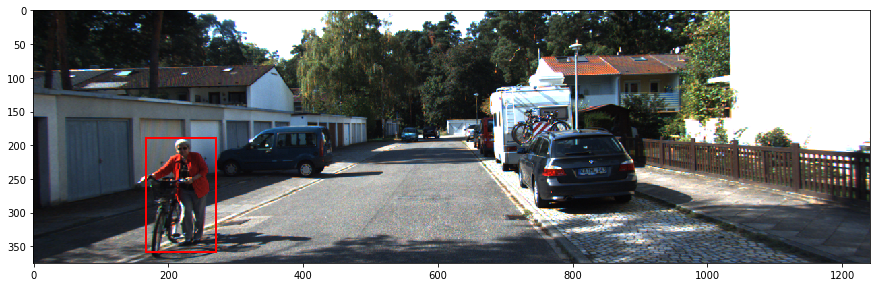

In [45]:
im = np.array(Image.open(datapath+pedestrian['image_id']+'.png'), dtype=np.uint8)

fig,ax = plt.subplots(figsize=(15,5))

ax.imshow(im)

box=pedestrian['gt_bbox']

rect1 = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')

ax.add_patch(rect1)

### Intersection over union

In [46]:
def get_inter_area(r1, r2):
    left = max(r1[0], r2[0])
    right = min(r1[2], r2[2])
    bottom = max(r1[1], r2[1])
    top = min(r1[3], r2[3])
    if (top-bottom)<0 and (right-left)<0:
        return 0
    else:
        return (top-bottom)*(right-left)

def get_union_area(r1, r2):
    return (r1[2]-r1[0])*(r1[3]-r1[1]) + (r2[2]-r2[0])*(r2[3]-r2[1]) - get_inter_area(r1, r2)

def get_inter_matrix(pp_image, gt_image):
    inter_matrix=[]
    for gt in gt_image:
        inter_line=[]
        gt_box= gt['gt_bbox']
        for pifpaf in pp_image:
            pp_box=pifpaf['gt_box']
            inter_line.append(get_inter_area(gt_box,pp_box)/get_union_area(gt_box, pp_box))
        inter_matrix.append(inter_line)
    return np.array(inter_matrix)

In [47]:
def match_gt_pifpaf(inter_matrix):
    max_val=np.max(inter_matrix)
    matches=[]
    while max_val>0.4:
        args_max=np.unravel_index(np.argmax(inter_matrix, axis=None), inter_matrix.shape)
        inter_matrix[args_max[0],:]=0
        inter_matrix[:,args_max[1]]=0
        matches.append(args_max)
        max_val=np.max(inter_matrix)
    return matches

In [48]:
labels_names[0]

'000000.txt'

In [49]:
%%time
train_data=[]
for i, image_id in enumerate(labels_names):
    
    #update_progress(i/len(labels_names))
    gt_ann = list(filter(lambda d: d['image_id']==image_id[:6], gt))
    
    #print('gt:',len(gt_ann))
    
    pp_ann = list(filter(lambda d: d['image_id']==image_id[:6], maskbox))
    
    #print('mask:', len(pp_ann))
    #print(i, len(gt_ann), len(pp_ann))
    matrix=get_inter_matrix(pp_ann, gt_ann)
    
    if matrix.size:
        matches = match_gt_pifpaf(matrix)
        
        for (i,j) in matches:
            pedestrian=cp.deepcopy(gt_ann[i])
            pedestrian['keypoints']=pp_ann[j]['og_keypoints']
            pedestrian['pp_box']=pp_ann[j]['gt_box']

            train_data.append(pedestrian)

CPU times: user 8.21 s, sys: 2.91 ms, total: 8.22 s
Wall time: 8.22 s


In [50]:
len(train_data)

1663

In [51]:
i=567
pedestrian=train_data[i]

In [52]:
pedestrian

{'image_id': '002707',
 'truncation': 0.0,
 'occlusion': 1,
 'obs_angle': 256.7763445475303,
 'gt_bbox': [580.82, 142.64, 605.92, 226.57],
 'gt_dim': [1.82, 0.67, 0.99],
 'gt_pos': [-0.4, 1.0, 15.89],
 'abs_orient': 165.6304289572687,
 'r_angle': -1.4420058314658963,
 'gt_orient': 167.0724347887346,
 'keypoints': array([[595.95355225, 150.95788574],
        [597.87054443, 148.95993042],
        [594.03656006, 148.95993042],
        [599.78753662, 149.95892334],
        [591.16101074, 149.95892334],
        [602.66308594, 157.95062256],
        [588.28552246, 158.94958496],
        [606.49707031, 168.9392395 ],
        [588.28552246, 170.93716431],
        [605.53857422, 177.92993164],
        [588.28552246, 180.92681885],
        [600.74603271, 178.92889404],
        [592.11956787, 179.92785645],
        [598.82904053, 197.90921021],
        [594.03656006, 196.9102478 ],
        [595.95355225, 212.89367676],
        [594.99505615, 212.89367676]]),
 'pp_box': [583.7805786132812,
  134.3

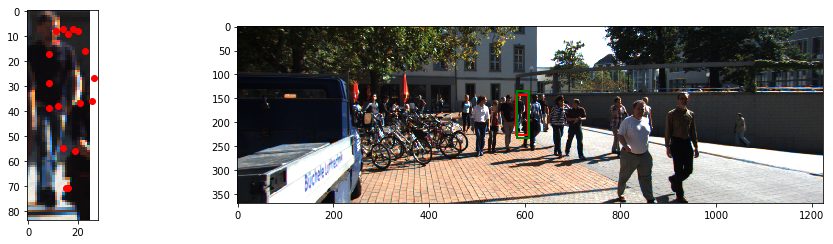

In [53]:
im = np.array(Image.open(datapath+pedestrian['image_id']+'.png'), dtype=np.uint8)

# Create figure and axes
fig,ax = plt.subplots(1, 2,figsize=(15,3.5))

# Display the image

box = pedestrian['gt_bbox']

box = list(map(lambda x: 0 if x<0 else x, box))
ax[0].imshow(im[int(box[1]):int(box[3]),int(box[0]):int(box[2])])
ax[1].imshow(im)

#kp = np.array(pedestrian['keypoints']).transpose()#.reshape((17,2))
kp = pedestrian['keypoints']

centered_kp=kp-[int(box[0]),int(box[1])]
rect1 = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')

box = pedestrian['pp_box']
rect2 = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='g',facecolor='none')


ax[0].scatter(centered_kp[:,0],centered_kp[:,1],c='r')
# Add the patch to the Axes
ax[1].add_patch(rect1)
ax[1].add_patch(rect2)
plt.tight_layout()

In [54]:
pickle_out = open("val_data_ours_kitti.pickle","wb")
pickle.dump(train_data, pickle_out)
pickle_out.close()